In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import librosa
from IPython import display
import sys
sys.path.append("../")
from DSP_prototype.DSP_algorithms import stft
from tensorflow.keras import layers
from tensorflow.keras import models

2025-01-16 20:50:56.473452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737057056.536912    7751 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737057056.555934    7751 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 20:50:56.686604: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


# Informacje o zbiorze danych "speech_commands"

## Etykiety
W zbiorze danych znajdują się pliki audio próbkowane z częstotliwością $f=16$kHz. Każdemu plikowi przypisana jest jedna z 12 dostępnych klas, które numerowane są w następujący sposób:

- 0 - down
- 1 - go
- 2 - left
- 3 - no
- 4 - off
- 5 - on
- 6 - right
- 7 - stop
- 8 - up
- 9 - yes
- 10 - silence
- 11 - unknown

In [3]:
sample_rate = 16000
label_strings = ["down", "go", "left", "no", "off", "on", "right", "stop", "up", "yes", "silence", "unknown"]
selected_labels = [1, 2, 3, 6, 7, 9, 10, 11]
selected_labels_dict = {x:i for i, x in enumerate(selected_labels)}
NUM_CLASSES = len(selected_labels)
commands = [label_strings[x] for x in selected_labels]

# Select data for training

In [4]:
dataset, info = tfds.load('speech_commands', with_info=True, as_supervised=True, split="test+validation+train")
print(f"Full dataset length: {len(dataset)}")

exclude_classes = [x for x in range(12) if x not in selected_labels]
dataset = dataset.shuffle(10000, seed=2137)

I0000 00:00:1737057064.374566    7751 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6161 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 Super, pci bus id: 0000:01:00.0, compute capability: 7.5


Full dataset length: 100503


In [5]:
def split_data_and_labels(dataset, length):
    data = []
    labels = []
    i = 0
    unknown_counter = 0
    for feature, label in dataset:
        if i == length:
            break
            
        pcm = feature.numpy()
        pcm_padded = np.pad(pcm, (0, sample_rate - len(pcm)), 'constant', constant_values=0)
        pcm_padded = pcm_padded.astype(np.float32)
        pcm_padded = librosa.resample(pcm_padded, orig_sr=16e3, target_sr=8e3)
        label = int(label.numpy())
        if label in selected_labels:
            if label == 11 and unknown_counter < 5:
                unknown_counter += 1
                
            if (label == 11 and unknown_counter == 5) or label != 11:
                data.append(pcm_padded)
                labels.append(selected_labels_dict.get(label))
                i += 1
                unknown_counter = 0
    return np.vstack(data), np.vstack(labels)


In [6]:
data, labels = split_data_and_labels(dataset, len(dataset))
NEW_DATASET_LENGTH = len(data)
print(f"Filtered length: {NEW_DATASET_LENGTH}")

2025-01-16 20:51:08.010995: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-01-16 20:52:00.618425: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Filtered length: 30069


<BarContainer object of 8 artists>

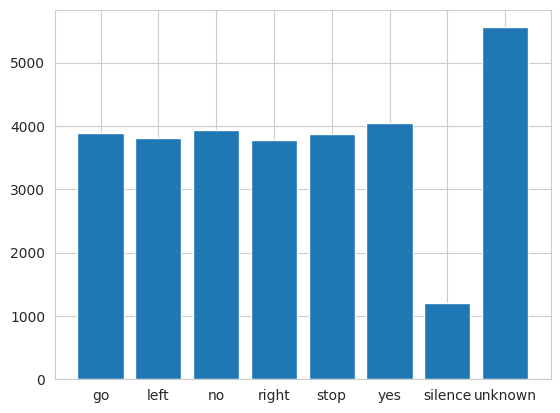

In [7]:
unique, counts = np.unique(labels, return_counts=True)

plt.bar(commands, counts)

# Split data into data and labels

In [8]:
TRAIN_PART = 0.7
VAL_PART = 0.1
TEST_PART = 0.2

train_data = data[:int(NEW_DATASET_LENGTH*TRAIN_PART)]
train_labels = labels[:int(NEW_DATASET_LENGTH*TRAIN_PART)]
TRAIN_LEN = len(train_data)

val_data = data[TRAIN_LEN:TRAIN_LEN+int(NEW_DATASET_LENGTH*VAL_PART)]
val_labels = labels[TRAIN_LEN:TRAIN_LEN+int(NEW_DATASET_LENGTH*VAL_PART)]
VAL_LEN = len(val_data)

test_data = data[TRAIN_LEN+VAL_LEN:]
test_labels = labels[TRAIN_LEN+VAL_LEN:]
TEST_LEN = len(test_data)

print(f"Train data length: {TRAIN_LEN}")
print(f"Validation data length: {VAL_LEN}")
print(f"Test data length: {TEST_LEN}")
print(f"Full dataset length: {NEW_DATASET_LENGTH}")

Train data length: 21048
Validation data length: 3006
Test data length: 6015
Full dataset length: 30069


# Normalize PCM audio vectors

In [ ]:
train_data.dtype

In [ ]:
print(f"[Train dataset] Max amplitude before normalization: {np.max(np.abs(train_data))}")
print(f"[Valid dataset] Max amplitude before normalization: {np.max(np.abs(val_data))}")
print(f"[Test dataset] Max amplitude before normalization: {np.max(np.abs(test_data))}")

train_data_max = np.max(np.abs(train_data))
valid_data_max = np.max(np.abs(val_data))
test_data_max = np.max(np.abs(test_data))

for i in range(len(train_data)):
    train_data[i] /= train_data_max
    print(i)
    
for i in range(len(val_data)):
    val_data[i] /= valid_data_max
    print(i)
    
for i in range(len(test_data)):
    test_data[i] /= test_data_max
    print(i)

print(f"[Train dataset] Max amplitude after normalization: {np.max(np.abs(train_data))}")
print(f"[Valid dataset] Max amplitude after normalization: {np.max(np.abs(val_data))}")
print(f"[Test dataset] Max amplitude after normalization: {np.max(np.abs(test_data))}")

# Spectrograms

In [ ]:
def get_spectrogram(pcm):
    D = librosa.stft(pcm, n_fft=256, hop_length=128, window='hann')
    return np.abs(D)

In [9]:
train_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in train_data])
valid_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in val_data])
test_data = np.array([np.abs(stft(x, fs=8e3, N=256, hop_size=128)[0]) for x in test_data])

In [10]:
train_data = train_data.reshape(len(train_data), train_data[0].shape[0], train_data[0].shape[1], 1)
valid_data = valid_data.reshape(len(valid_data), valid_data[0].shape[0], valid_data[0].shape[1], 1)
test_data = test_data.reshape(len(test_data), test_data[0].shape[0], test_data[0].shape[1], 1)

# Model

In [11]:

# Update input shape
input_shape = train_data[0].shape  # This will now be (129, 126, 1)
print('Input shape:', input_shape)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(train_data)

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.SeparableConv2D(32, 3, activation='leaky_relu'),
    layers.SeparableConv2D(64, 3, activation='leaky_relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.5),
    layers.SeparableConv2D(64, 3, activation='leaky_relu'),
    layers.SeparableConv2D(128, 3, activation='leaky_relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.5),
    layers.SeparableConv2D(128, 3, activation='leaky_relu'),
    layers.SeparableConv2D(256, 3, activation='leaky_relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='leaky_relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax'),
])

model.summary()

Input shape: (129, 61, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 30, 30, 32)     │            73 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 28, 28, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 12, 12, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 10, 10, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 3, 3, 128)      │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 1, 1, 256)      │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,916 (331.71 KB)

 Trainable params: 84,913 (331.69 KB)

 Non-trainable params: 3 (16.00 B)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [13]:
train_labels = train_labels.astype(np.float32)
valid_labels = val_labels.astype(np.float32)

In [14]:
EPOCHS = 100
history = model.fit(train_data, train_labels,
    validation_data=(valid_data, valid_labels),
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
    batch_size=512
)

Epoch 1/100


/home/vistek528/anaconda3/envs/DeepLearning/lib/python3.9/site-packages/keras/src/backend/tensorflow/nn.py:678: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1737057252.121204    7843 service.cc:148] XLA service 0x719f040962d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737057252.121256    7843 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 Super, Compute Capability 7.5
2025-01-16 20:54:12.183894: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737057252.479997    7843 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.1559 - loss: 2.0780

I0000 00:00:1737057259.166528    7843 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 177ms/step - accuracy: 0.1668 - loss: 2.0629 - val_accuracy: 0.2179 - val_loss: 2.0223
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1637 - loss: 2.0423 - val_accuracy: 0.2179 - val_loss: 2.0169
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1734 - loss: 2.0336 - val_accuracy: 0.2319 - val_loss: 1.9299
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2086 - loss: 1.9199 - val_accuracy: 0.2838 - val_loss: 1.7526
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2813 - loss: 1.7665 - val_accuracy: 0.3533 - val_loss: 1.6185
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3297 - loss: 1.6553 - val_accuracy: 0.3856 - val_loss: 1.5094
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3698 - loss: 1.5732 - val_accuracy: 0.4348 - val_loss: 1.4326
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4114 - loss: 1.4840 - val_accuracy: 0.4780 - val

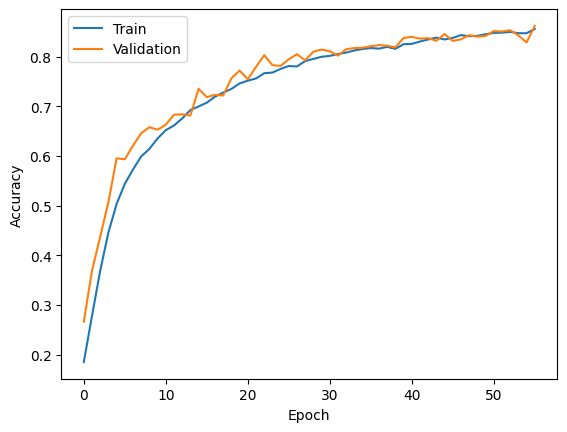

In [43]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Train", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

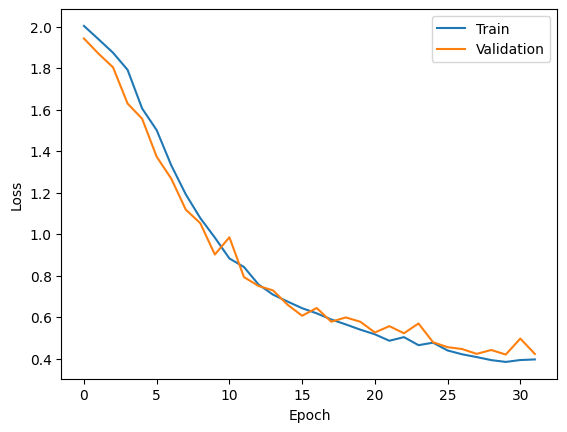

In [18]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
raw_test_data, raw_data_label = next(iter(dataset["test"].take(1)))

In [ ]:
display.Audio(raw_test_data.numpy(), rate=16000)

In [ ]:
# Add batch dimension to the first sample of test_data
sample = test_data[0]


img_array = tf.expand_dims(sample, 0)
print(img_array.shape)

prediction = np.argmax(model.predict(img_array), axis=1)
print(f"Prediction: {prediction}")

In [44]:
results = model.evaluate(test_data, test_labels, batch_size=128)
print("test loss, test acc:", results)

2025-01-16 20:00:53.272787: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[128,16,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,1,32,32]{3,2,1,0}, f32[16,1,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-16 20:00:53.313146: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[128,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,16,30,30]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

36/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8746 - loss: 0.3969

2025-01-16 20:00:54.006982: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[127,16,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[127,1,32,32]{3,2,1,0}, f32[16,1,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-16 20:00:54.050538: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[127,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[127,16,30,30]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8727 - loss: 0.3990
test loss, test acc: [0.40724632143974304, 0.865835428237915]


In [45]:
y_pred = np.argmax(model.predict(test_data), axis=1)

2025-01-16 20:01:03.772853: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,16,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,32,32]{3,2,1,0}, f32[16,1,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-16 20:01:03.829429: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,16,30,30]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-01-16 20:01:04.687659: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[31,16,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,1,32,32]{3,2,1,0}, f32[16,1,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-16 20:01:04.717903: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[31,32,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,16,30,30]{3,2,1,0}, f32[32,16,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config=

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [22]:
import seaborn as sns

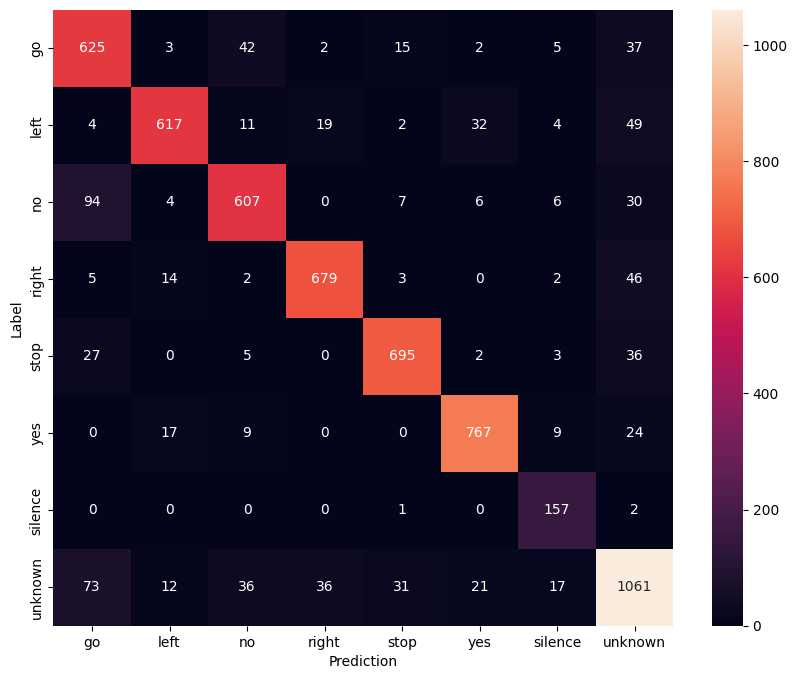

In [46]:
confusion_mtx = tf.math.confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [47]:
model.save("/home/vistek528/TRA_PROJ/NET_prototype/tra_medium_model_86test_acc_8kHz_PioterSTFT.keras")

# Fine-tuning

In [28]:
model = tf.keras.models.load_model("tra_medium_model_with_recursive_layer_86test_acc_8kHz_PioterSTFT.keras")

In [29]:
lr = 1e-5
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [30]:
EPOCHS = 100
history = model.fit(train_data, train_labels,
    validation_data=(valid_data, valid_labels),
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
    batch_size=1024
)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.8692 - loss: 0.3685 - val_accuracy: 0.8619 - val_loss: 0.3973
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8792 - loss: 0.3388 - val_accuracy: 0.8629 - val_loss: 0.3939
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8814 - loss: 0.3397 - val_accuracy: 0.8639 - val_loss: 0.3907
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8803 - loss: 0.3396 - val_accuracy: 0.8643 - val_loss: 0.3894
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8811 - loss: 0.3435 - val_accuracy: 0.8646 - val_loss: 0.3886
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8859 - loss: 0.3344 - val_accuracy: 0.8656 - val_loss: 0.3878
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8806 - loss: 0.3388 - val_accuracy: 0.8669 - val_loss: 0.3866
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8832 - loss: 0.3384 - val_accuracy: 0.